In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pygad
from time import time

In [13]:
'''
The provided evaluation function with minor modifications to reduce runtime
'''
def func(F,s0,link_flows_real,PRINT, A, B):

    #parameters
    
    t = time()
    
    t_link = np.array([30,3,28,3,15,10,0,0,10,0])
    t_path = np.dot(A.T,t_link)

    alpha = 1

    r = np.array([10])

    G = np.dot((F-np.eye(10)),A)

    #Network Structure
    N = {
        1:[2,4,7],
        2:[3,5],
        3:[4],
        4:[],
        5:[5],
        6:[3],
        7:[8],
        8:[4]
    } ## Node Structure

    link_node = np.array([[1, 1, 4],
            [2, 1, 2],
            [3, 2, 3],
            [4, 3, 4],
            [5, 5, 6],
            [6, 7, 8],
            [7, 2, 3], 
            [8, 6, 3],
            [9, 1, 7],
            [10, 8, 4],]) ## Link and node

    #Origin List
    O = np.array([1])
    D = np.array([4])

    #cost matrix
    c = np.ones((8,8)) * np.inf
    
    # print("Group 0: %.6fs" % (time() - t))
    t = time()
    
    for i in range(8):
        c[i,i] = 0
    for i in range(len(link_node)):
        link_id = link_node[i,0]
        start = link_node[i,1]
        end = link_node[i,2]
        c[start - 1, end - 1] = t_link[link_id-1]
    
    # print("Group 1: %.6fs" % (time() - t))
    t = time()

    od_num = len(r)
    link_num = len(link_node)
    node_num = len(N)
    path_num = A.shape[1]

    ###OBJECTIVE
    def obj(h):
        return sum(np.multiply((np.log(h)-1),h))+np.dot(t_path,h)
    '''
    def obj_der(h):
        der = np.zeros_like(h)
        for i in range(len(h)):
            der[i] = np.log(h[i])+t_path[i]
        return der
    '''
    def obj_der(h):
        return np.log(h) + t_path

    def obj_hess(h):
        hess = np.zeros((len(h),len(h)))
        for i in range(len(h)):
            hess[i,i] = 1/h[i]
        return hess


    ###CONSTRAINTS
    from scipy.optimize import LinearConstraint
    LOWER_cap = -s0
    UPPER_cap = [np.inf]*link_num
    Capacity_constraint = LinearConstraint(G,LOWER_cap,UPPER_cap)

    LOWER_r = np.ones((od_num))*10
    UPPER_r = np.ones((od_num))*10
    R_constraint = LinearConstraint(B,LOWER_r,UPPER_r)

    LOWER_nn = np.zeros((path_num))
    UPPER_nn = [np.inf]*path_num
    NN_constraint = LinearConstraint(np.eye(path_num),LOWER_nn,UPPER_nn)

    # print("Group 2: %.6fs" % (time() - t))
    t = time()

    ###OPTIMIZE
    for i in range(10):
        h0 = np.ones((path_num))*2.5
        Solution = minimize(obj, h0, method='trust-constr', jac=obj_der, hess=obj_hess,
                   constraints=[Capacity_constraint,R_constraint,NN_constraint],
                   options={'verbose': 0,'disp': False}) 
        # print(i, Solution.x, Solution.message)
        if Solution.status != 0:
            break
    
    # print("Group 3: %.6fs" % (time() - t))
    t = time()

    lm = Solution.v[0]
    h_UE = Solution.x
    capacity = np.dot(np.dot(F,A),h_UE)+s0
    link_flows = np.dot(A,h_UE)
    
    error = np.linalg.norm(link_flows-link_flows_real) # L2 norm of the difference between the real flows and the flows solved from the given F

    if PRINT == 1:
        print ("F: ", np.round(F, 3))
        print ("Path Flow: ",np.round(h_UE,3))
        print ("Capacity: ",np.round(np.dot(np.dot(F,A),h_UE)+s0,3))
        print ("Link flow: ",np.round(np.dot(A,h_UE),3))
        print ("Error:", np.round(error, 3))
        print ("-----------------------------------------------")
        
    # print("Group 4: %.6fs" % (time() - t))
    t = time()

    return link_flows, capacity, error #output steady-state link flows and capacities and the error


In [14]:
### specify the input functions

# set a random F
F = np.zeros((10,10))

#s0
s0 = np.array([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,5,5,5,np.inf])

#real link flows
link_flows_real = np.array([0.89264769, 4.56191687, 0.01650574, 4.56191687, 4.54541114,
       4.54543543, 4.54541114, 4.54541114, 4.54543543, 4.54543543])

A = pd.read_csv('A Matrix.csv', index_col=0).values
B = pd.read_csv('B Matrix.csv', index_col=0).values

In [15]:
F_real = pd.read_csv('F Matrix.csv', index_col=0).values
F_real

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [16]:
link_flows, capacity, error = func(F,#the given F
                                   s0,#the given s0
                                   link_flows_real, # real link flows
                                   0, #print results (1) or not (0)
                                   A, B)
error

1.5538524446395765

In [17]:
link_flows, capacity, error = func(F_real, s0, link_flows_real, 0, A, B)
error

1.1227738477047337e-08

## Defining an alternative score for differences between real flows and computed flows

TS-SS computes the similarity between two vectors from diverse perspective and generates the similarity value from two vectors not only from the angle and Euclidean distance between them, but also the difference between their magnitudes.

https://www.computer.org/csdl/proceedings-article/bigdataservice/2016/2251a142/12OmNweBUID

Test runs with the same hyperparameters show that using TS-SS similarity yields slightly better results than using L2 norm.

In [18]:
def cosine(v0, v1):
    dot_product = np.dot(v0, v1.T)
    denominator = (np.linalg.norm(v0) * np.linalg.norm(v1))
    return dot_product/denominator
    
def euclidean(v0, v1):
    return np.linalg.norm(v0 - v1)

def theta(v0, v1):
    return np.arccos(cosine(v0, v1)) + np.radians(10)

def triangle(v0, v1):
    t = np.radians(theta(v0, v1))
    return ((np.linalg.norm(v0) * np.linalg.norm(v1)) * np.sin(t))/2

def magnitude_diff(v0, v1):
    return abs((np.linalg.norm(v0) - np.linalg.norm(v1)))

def sector(v0, v1):
    ED = euclidean(v0, v1)
    MD = magnitude_diff(v0, v1)
    t = theta(v0, v1)
    return math.pi * (ED + MD)**2 * t/360

def ts_ss(v0, v1):
    v0[np.isinf(v0)] = 0
    v1[np.isinf(v1)] = 0
    score = triangle(v0, v1) * sector(v0, v1)
    return score

In [19]:
# Try the TS-SS similarity function
tmp_v0 = np.random.rand(10)
tmp_v1 = np.random.rand(10)
print(ts_ss(tmp_v0, tmp_v1))
print(ts_ss(tmp_v0, tmp_v0)) # Identical vectors
print(ts_ss(tmp_v0, -5*tmp_v0)) # Vectors of different directions & very different magnitudes

0.0005569253043530737
0.0
6.407215524980118


$$\text{fitness score} = \frac{1}{2^{\text{similarity score}}}\\
\text{similarity score = 0 (identical vectors)} \iff \text{fitness score} = 1$$

In [78]:
'''
The fitness function used in genetic algorithm.
Both scores (L2 norm & TS-SS) are recorded.
For both similarity functions, bigger scores indicate bigger differences -- we need to minimize this.
The fitness function priorities higher fitness values. So we need to invert the similarity scores.
Fitness value = 1 / 2^(similarity)
'''
def fitness_func(solution, solution_idx):
    sol = np.array(solution).reshape(-1, 1).reshape(10, 10)
    link_flows, _, score = func(sol, s0, link_flows_real, 0, A, B) # score = L2 norm
    diff = ts_ss(link_flows, link_flows_real) # diff = TS-SS score
    score_inv = 1 / (2**diff) # Use score or diff here to change which similarity score is used
    all_errors.append((score, diff))
    return score_inv

In [79]:
fitness_function = fitness_func

num_generations = 700
num_parents_mating = 4

sol_per_pop = 10
num_genes = F.reshape(-1, 1).shape[0]

init_range_low = 0
init_range_high = 0

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 1

In [80]:
def get_model(num_generations, sol_per_pop, mutation_percent_genes):
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes)
    return ga_instance

## Parameter validation
To be checked:
- Number of generations: 50, 150, 500, 700, 850
- Solutions per generation: 5, 10, 16, 24, 32
- Mutation percentage: 1, 5, 10

To be recorded:
- Runtime
- Best solution: F matrix, computed link flows, capacity, best solution generation
- All errors: norm & TS-SS

In [123]:
def param_validation(num_generations, sol_per_pop, mutation_percent_genes):
    print(f"Validation in session:\n num_generations={num_generations}\n sol_per_pop={sol_per_pop} \n mutation_percent_genes={mutation_percent_genes}")
    
    ga = get_model(num_generations, sol_per_pop, mutation_percent_genes)
    
    results = dict()
    results['num_generations'] = num_generations
    results['sol_per_pop'] = sol_per_pop
    results['mutation_percent_genes'] = mutation_percent_genes
    
    t = time()
    ga.run()
    results['runtime'] = time() - t
    
    solution, solution_fitness, solution_idx = ga.best_solution()
    sol = solution.reshape(10, 10)
    results['F'] = sol
    link_flows, capacity, error = func(sol, s0, link_flows_real, 0, A, B)
    results['link_flows'] = link_flows
    results['capacity'] = capacity
    results['best_sol_generation'] = ga.best_solution_generation
    results['best_error'] = error
    
    if len(validation_results) > 0:
        last_error_idx = validation_results[-1]['error_idx']
    else:
        last_error_idx = 0
    all_round_errors = all_errors[last_error_idx:]
    results['error_norms'] = [error[0] for error in all_round_errors]
    results['error_tsss'] = [error[1] for error in all_round_errors]
    results['error_idx'] = len(all_errors)
    validation_results.append(results)
    
    print(f"best_sol_generation={ga.best_solution_generation}, best norm error={error}")
    print("\n========\n")

In [132]:
fitness_function = fitness_func
num_parents_mating = 4
num_genes = F.reshape(-1, 1).shape[0]
init_range_low = 0
init_range_high = 0
parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"

In [130]:
all_errors = []

In [131]:
validation_results = []

### Number of generations

In [133]:
sol_per_pop = 10
mutation_percent_genes = 1
test_values = [50, 150, 500, 700, 850]

for num_generations in test_values:
    param_validation(num_generations, sol_per_pop, mutation_percent_genes)

Validation in session:
 num_generations=50
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=47, best norm error=0.014894237117712929


Validation in session:
 num_generations=150
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=147, best norm error=0.08549269680660258


Validation in session:
 num_generations=500
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=424, best norm error=0.01347328526538502


Validation in session:
 num_generations=700
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=648, best norm error=0.02463671502173149


Validation in session:
 num_generations=850
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=850, best norm error=0.02714373566773137




### Solutions per population

In [134]:
num_generations = 150
mutation_percent_genes = 1
test_values = [5, 10, 16, 24, 32]

for sol_per_pop in test_values:
    param_validation(num_generations, sol_per_pop, mutation_percent_genes)

Validation in session:
 num_generations=150
 sol_per_pop=5 
 mutation_percent_genes=1
best_sol_generation=70, best norm error=0.3201547049618375


Validation in session:
 num_generations=150
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=149, best norm error=0.5553874130036205


Validation in session:
 num_generations=150
 sol_per_pop=16 
 mutation_percent_genes=1
best_sol_generation=146, best norm error=0.01607287225172193


Validation in session:
 num_generations=150
 sol_per_pop=24 
 mutation_percent_genes=1
best_sol_generation=148, best norm error=0.044561253699954444


Validation in session:
 num_generations=150
 sol_per_pop=32 
 mutation_percent_genes=1
best_sol_generation=135, best norm error=0.04919177775329278




### Mutation percentage

In [135]:
num_generations = 150
sol_per_pop = 10
test_values = [1, 5, 10]

for mutation_percent_genes in test_values:
    param_validation(num_generations, sol_per_pop, mutation_percent_genes)

Validation in session:
 num_generations=150
 sol_per_pop=10 
 mutation_percent_genes=1
best_sol_generation=143, best norm error=0.08287901059630559


Validation in session:
 num_generations=150
 sol_per_pop=10 
 mutation_percent_genes=5
best_sol_generation=136, best norm error=0.016876991330834878


Validation in session:
 num_generations=150
 sol_per_pop=10 
 mutation_percent_genes=10
best_sol_generation=78, best norm error=0.07060309141648116




In [138]:
val_df = pd.DataFrame(validation_results)
val_df

,num_generations,sol_per_pop,mutation_percent_genes,runtime,F,link_flows,capacity,best_sol_generation,best_error,error_norms,error_tsss,error_idx
0,50,10,1,22.850323,"[[-0.608121802267424, 0.2092029677315439, -0.2...","[0.897979004335572, 4.563045009695624, 0.02137...","[inf, inf, inf, inf, inf, inf, 4.5416735506607...",47,0.014894,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",469
1,150,10,1,164.739910,"[[-0.7509427520132204, 0.5460327031843482, -1....","[0.8666806159487974, 4.5440705716263405, 0.003...","[inf, inf, inf, inf, inf, inf, 9.8461950585773...",147,0.085493,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",1838
2,500,10,1,718.467917,"[[0.9812263872513667, -0.7635677488255963, 0.3...","[0.8919687819905308, 4.564562880545156, 0.0123...","[inf, inf, inf, inf, inf, inf, 4.5522421553137...",424,0.013473,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",6357
3,700,10,1,777.441926,"[[-1.9401256192817453, -1.355952594531909, 2.8...","[0.8973385730602844, 4.550017686693855, 0.0044...","[inf, inf, inf, inf, inf, inf, 4.5457356021386...",648,0.024637,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",12676
4,850,10,1,793.522201,"[[0.8651190311678796, 2.062155526490753, 0.676...","[0.9032565599961546, 4.5542496118068785, 0.000...","[inf, inf, inf, inf, inf, inf, 4.5543914742418...",850,0.027144,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",20345
5,150,5,1,59.273318,"[[-0.7170316151975391, 0.0, 0.0, -0.2862637390...","[0.8446395326910763, 4.467636972767998, 0.0070...","[inf, inf, inf, inf, inf, inf, 4.4606001443330...",70,0.320155,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",20954
6,150,10,1,280.917739,"[[0.7854248787915081, 0.1177936252266274, 0.0,...","[0.7216519507869086, 4.509261203343456, 0.1513...","[inf, inf, inf, inf, inf, inf, 4.3579656309349...",149,0.555387,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",22323
7,150,16,1,352.155956,"[[-0.792711809882666, 0.7523658325790066, -0.5...","[0.8872567250084654, 4.566179736586122, 0.0263...","[inf, inf, inf, inf, inf, inf, 4.5398702586020...",146,0.016073,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",24604
8,150,24,1,323.769517,"[[0.0, 0.6106162540966813, 0.0, 0.258993531828...","[0.889399868213993, 4.581211349985974, 0.02428...","[inf, inf, inf, inf, inf, inf, 4.5569440280593...",148,0.044561,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",28101
9,150,32,1,680.099241,"[[0.7412264224362493, -1.2151854255209273, 0.0...","[0.8816506559961024, 4.550910931131085, 0.0195...","[inf, inf, inf, inf, inf, inf, 4.5324640847445...",135,0.049192,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",32814


In [140]:
val_df.to_csv('./validation_results.csv')

In [141]:
for val in validation_results:
    print(len(val['error_norms']))

469
1369
4519
6319
7669
609
1369
2281
3497
4713
1369
1369
1369


In [80]:
validation_results = pd.read_csv('./validation_results.csv', index_col=0)
validation_results

,num_generations,sol_per_pop,mutation_percent_genes,runtime,F,link_flows,capacity,best_sol_generation,best_error,error_norms,error_tsss,error_idx
0,50,10,1,22.850323,[[-0.6081218 0.20920297 -0.27770026 0. ...,[0.897979 4.56304501 0.02137497 4.56304501 4...,[ inf inf inf i...,47,0.014894,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",469
1,150,10,1,164.739910,[[-7.50942752e-01 5.46032703e-01 -1.57687949e...,[8.66680616e-01 4.54407057e+00 3.04029199e-03 ...,[ inf inf inf inf ...,147,0.085493,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",1838
2,500,10,1,718.467917,[[ 9.81226387e-01 -7.63567749e-01 3.55873944e...,[0.89196878 4.56456288 0.0123623 4.56456288 4...,[ inf inf inf i...,424,0.013473,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",6357
3,700,10,1,777.441926,[[-1.94012562e+00 -1.35595259e+00 2.81100511e...,[8.97338573e-01 4.55001769e+00 4.43055521e-03 ...,[ inf inf inf i...,648,0.024637,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",12676
4,850,10,1,793.522201,[[ 0.86511903 2.06215553 0.67681553 1.61794...,[9.03256560e-01 4.55424961e+00 3.07666490e-04 ...,[ inf inf inf i...,850,0.027144,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",20345
5,150,5,1,59.273318,[[-0.71703162 0. 0. -0.28626...,[0.84463953 4.46763697 0.00705887 4.46763697 4...,[ inf inf inf inf ...,70,0.320155,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",20954
6,150,10,1,280.917739,[[ 0.78542488 0.11779363 0. -0.64022...,[0.72165195 4.5092612 0.15132051 4.5092612 4...,[ inf inf inf inf ...,149,0.555387,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",22323
7,150,16,1,352.155956,[[-7.92711810e-01 7.52365833e-01 -5.60913877e...,[0.88725673 4.56617974 0.0263264 4.56617974 4...,[ inf inf inf inf ...,146,0.016073,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",24604
8,150,24,1,323.769517,[[ 0.00000000e+00 6.10616254e-01 0.00000000e...,[0.88939987 4.58121135 0.02428871 4.58121135 4...,[ inf inf inf inf ...,148,0.044561,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",28101
9,150,32,1,680.099241,[[ 0.74122642 -1.21518543 0. 1.16440...,[0.88165066 4.55091093 0.01958037 4.55091093 4...,[ inf inf inf inf ...,135,0.049192,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",32814


In [154]:
def plot_errors(errors, title=''):
    plt.figure(figsize=(15, 7))
    x = np.arange(len(errors))
    plt.plot(x, errors, linewidth=0.25)
    median = np.median(errors)
    plt.scatter([np.argmin(errors), np.argmax(errors), errors.index(median)], [np.min(errors), np.max(errors), median], c='r', marker='x')
    plt.text(np.argmin(errors), np.min(errors), "Min: {:.4f}".format(np.min(errors)))
    plt.text(np.argmax(errors), np.max(errors), "Max: {:.4f}".format(np.max(errors)))
    plt.text(errors.index(median), median, "Median: {:.4f}".format(median))

    z = np.polyfit(x, errors, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),"r--")
    
    plt.xlabel('Iterations')
    plt.ylabel('Error')

    plt.title(title + ", mean error={:.4f}, std={:.4f}".format(np.mean(errors), np.std(errors)))

    plt.show()

In [150]:
def describe_errors(errors):
    return pd.DataFrame(errors).describe()

In [151]:
def parse_errors(raw):
    return list(np.asarray(raw.replace('[', '').replace(']', '').split(', '), dtype=float))

# parse_errors(validation_results.iloc[0]['error_norms'])

In [152]:
def parse_arr_no_space(raw):
    raw_list = raw.replace('[', '').replace(']', '').split(' ')
    return np.asarray([elem.strip() for elem in raw_list if elem != ''], dtype=float)

# parse_arr_no_space(validation_results.iloc[0]['capacity'])

In [85]:
def parse_F(raw):
    matrix = []
    for line in raw.replace('[[', '').replace(']]', '').split(']\n ['):
        vector = np.asarray(line.split(), dtype=float)
        matrix.append(vector)
    return np.array(matrix)

# parse_F(validation_results.iloc[0]['F'])

In [87]:
validation_results['F'] = validation_results['F'].apply(lambda x: parse_F(x))
validation_results['link_flows'] = validation_results['link_flows'].apply(lambda x: parse_arr_no_space(x))
validation_results['capacity'] = validation_results['capacity'].apply(lambda x: parse_arr_no_space(x))
validation_results['error_norms'] = validation_results['error_norms'].apply(lambda x: parse_errors(x))
validation_results['error_tsss'] = validation_results['error_tsss'].apply(lambda x: parse_errors(x))

validation_results.head(2)

,num_generations,sol_per_pop,mutation_percent_genes,runtime,F,link_flows,capacity,best_sol_generation,best_error,error_norms,error_tsss,error_idx
0,50,10,1,22.850323,"[[-0.6081218, 0.20920297, -0.27770026, 0.0, -0...","[0.897979, 4.56304501, 0.02137497, 4.56304501,...","[inf, inf, inf, inf, inf, inf, 4.54167355, 16....",47,0.014894,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",469
1,150,10,1,164.739910,"[[-0.750942752, 0.546032703, -1.57687949, 0.50...","[0.866680616, 4.54407057, 0.00304029199, 4.544...","[inf, inf, inf, inf, inf, inf, 9.84619506, 4.5...",147,0.085493,"[1.5538524446395765, 1.5538524446395765, 1.553...","[0.0064480027656263214, 0.0064480027656263214,...",1838


### Visuals: num_generations

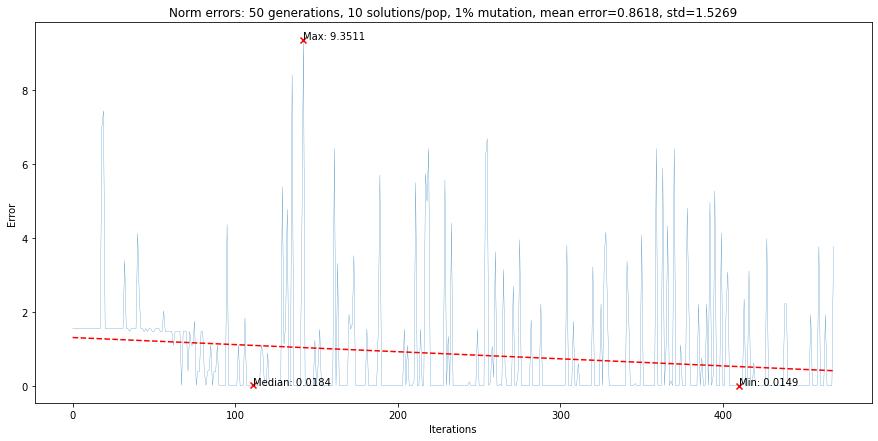

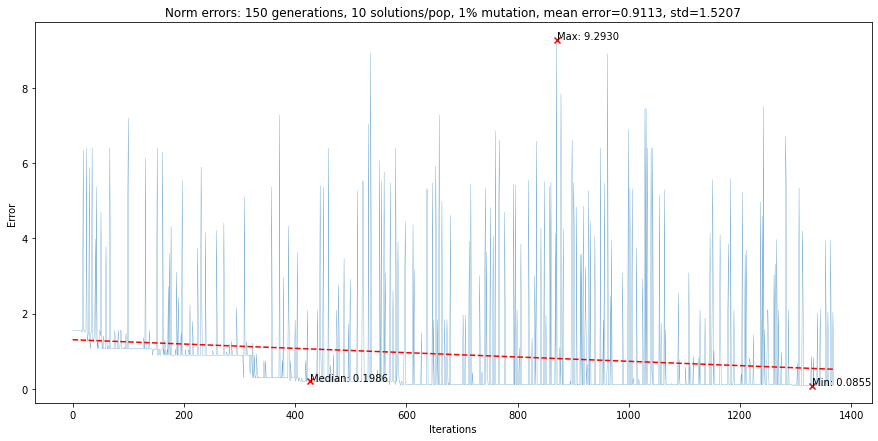

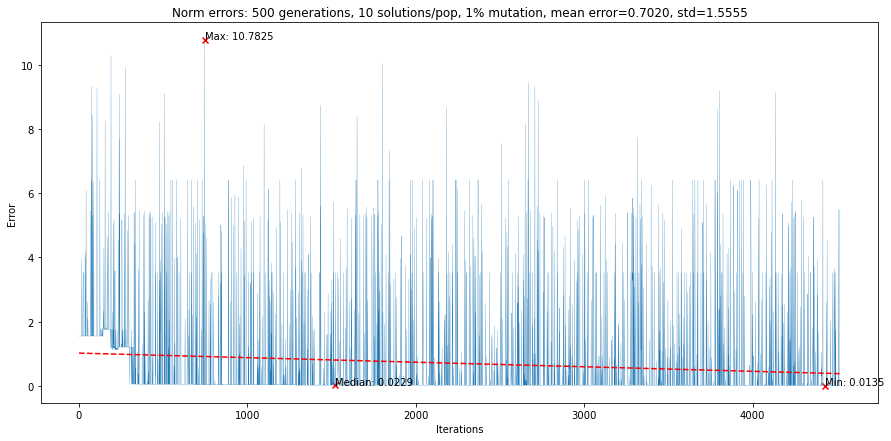

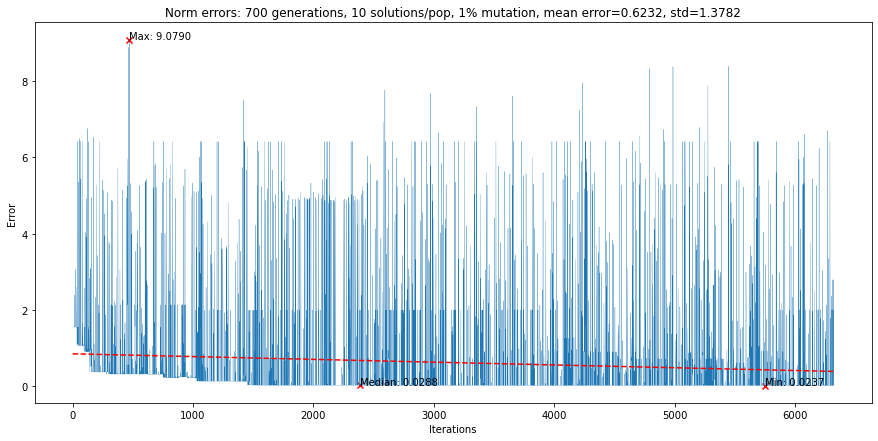

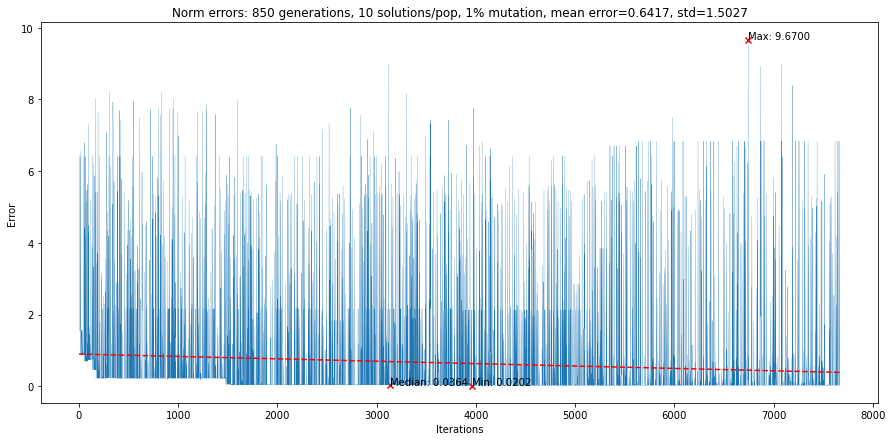

In [155]:
for i in range(5):
    result = validation_results.iloc[i]
    title = f"{result['num_generations']} generations, {result['sol_per_pop']} solutions/pop, {result['mutation_percent_genes']}% mutation"
    plot_errors(result['error_norms'], "Norm errors: " + title)
    # plot_errors(result['error_tsss'], "TS-SS errors: " + title)

### Visuals: solutions per population

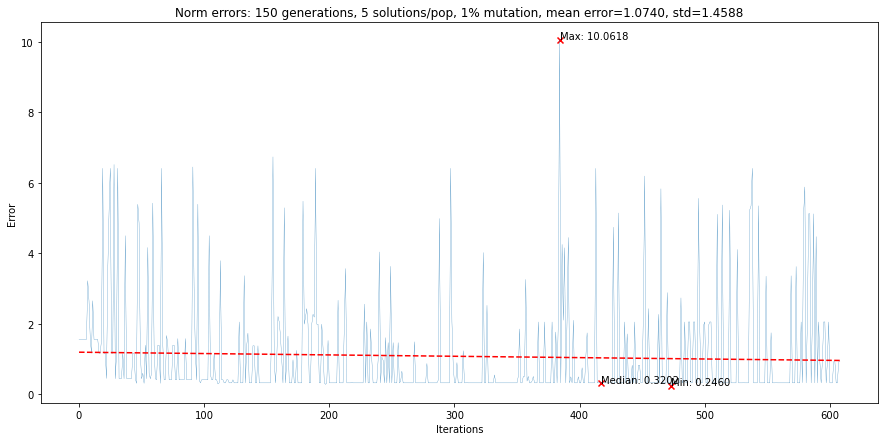

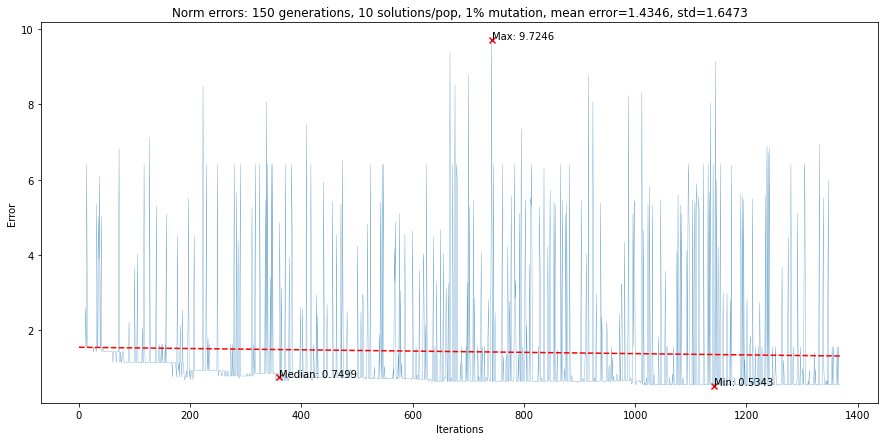

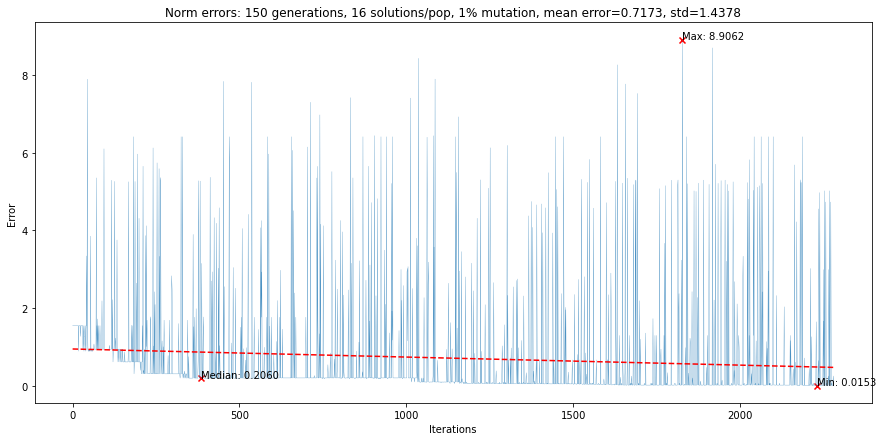

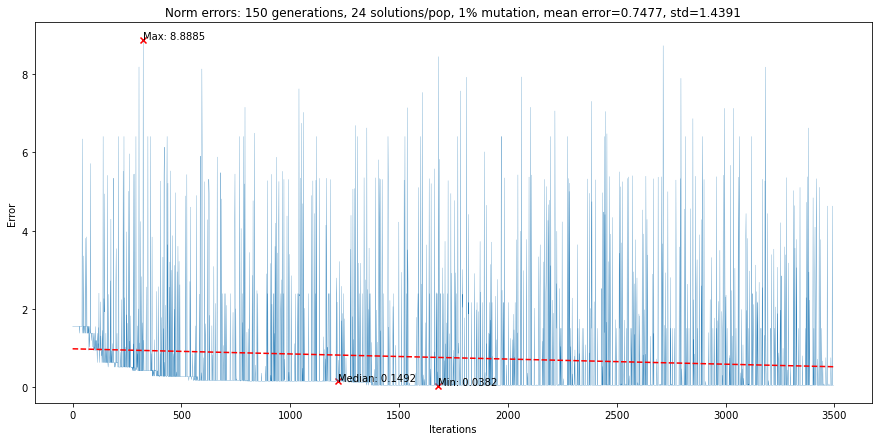

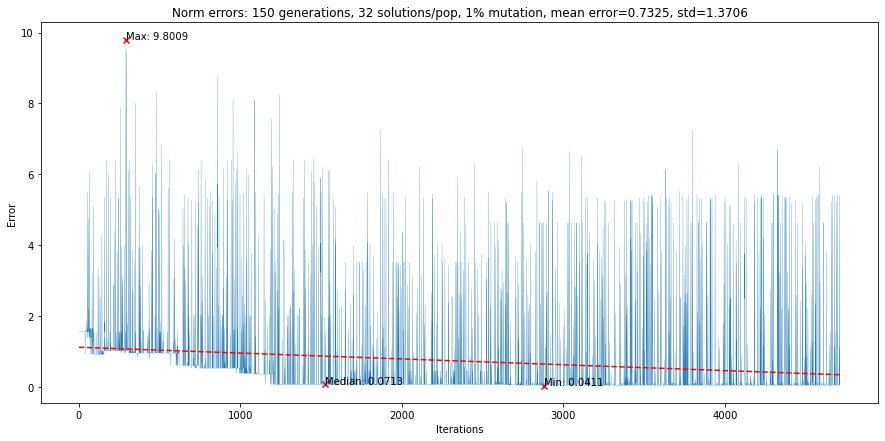

In [156]:
for i in range(5, 10):
    result = validation_results.iloc[i]
    title = f"{result['num_generations']} generations, {result['sol_per_pop']} solutions/pop, {result['mutation_percent_genes']}% mutation"
    plot_errors(result['error_norms'], "Norm errors: " + title)
    # plot_errors(result['error_tsss'], "TS-SS errors: " + title)

### Visuals: mutation percent

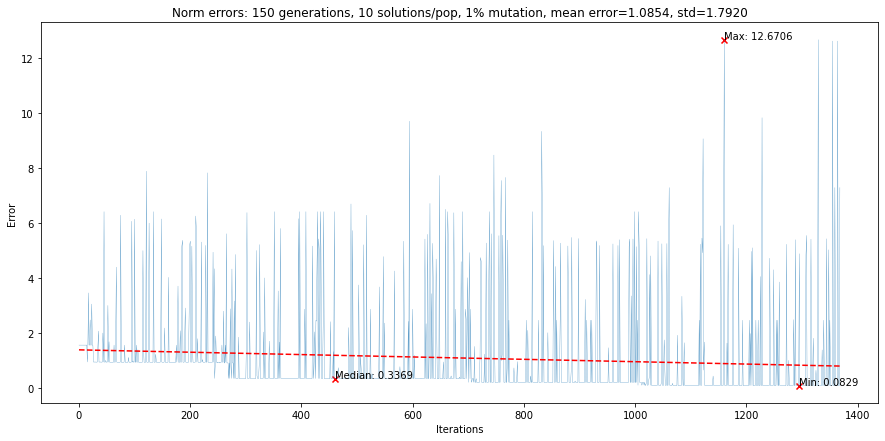

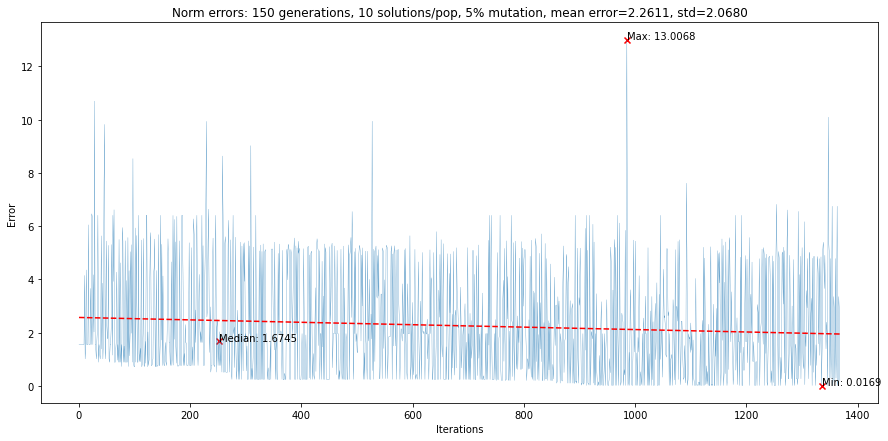

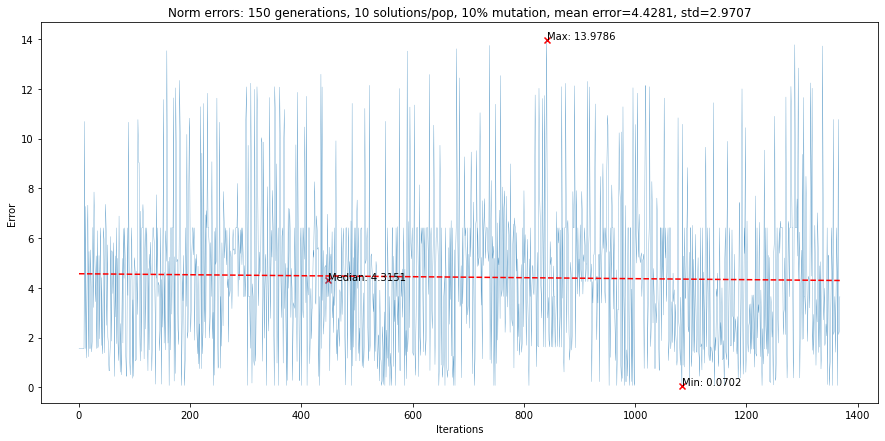

In [157]:
for i in range(10, 13):
    result = validation_results.iloc[i]
    title = f"{result['num_generations']} generations, {result['sol_per_pop']} solutions/pop, {result['mutation_percent_genes']}% mutation"
    plot_errors(result['error_norms'], "Norm errors: " + title)
    # plot_errors(result['error_tsss'], "TS-SS errors: " + title)